In [ ]:
pip install tensorflow tensorflow scikit-learn matplotlib optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, SimpleRNN, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Market_Data.csv to Market_Data.csv


In [ ]:
# Load the data where the first row contains headers
correct_data = pd.read_csv('Market_Data.csv', header=0)

# Display the DataFrame
correct_data.head()

# Print all column names
print("Columns in the DataFrame:", correct_data.columns)

# Ensure the Date column is correctly parsed and available
if 'Date' in correct_data.columns:
    # Convert the 'Date' column to datetime
    correct_data['Date'] = pd.to_datetime(correct_data['Date'], errors='coerce')

    # Print the first few rows to verify
    print("Data with Date column:")
    print(correct_data.head())

# Strip leading and trailing spaces from column names
correct_data.columns =correct_data.columns.str.strip()

# Preprocess the data
correct_data['Date'] = pd.to_datetime(correct_data['Date'], format='%Y-%m-%d', errors='raise')
correct_data = correct_data.sort_values('Date')
correct_data.set_index('Date', inplace=True)

# Drop rows with NaN values resulting from technical indicators calculation
correct_data = correct_data.dropna()

# Define features for scaling
features = ['PX_LAST', 'Return', 'SMA_15', 'SMA_45', 'RSI', 'MACD', 'Bollinger_Mid', 'Bollinger_Upper']

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(correct_data[features])


Columns in the DataFrame: Index(['Date', 'PX_LAST', 'Return', 'SMA_15', 'SMA_45', 'RSI', 'MACD',
       'Bollinger_Mid', 'Bollinger_Upper'],
      dtype='object')
Data with Date column:
        Date   PX_LAST    Return       SMA_15       SMA_45        RSI  \
0 2010-08-03  23047.31  0.005383  23024.53667  22617.92667  57.169175   
1 2010-09-03  23196.20  0.006460  23033.52267  22670.31111  61.521681   
2 2010-10-03  23412.41  0.009321  23056.73067  22724.88289  66.798115   
3 2010-11-03  23666.33  0.010846  23099.61267  22778.66333  71.705329   
4 2010-12-03  24141.72  0.020087  23168.04400  22837.71911  78.201260   

         MACD  Bollinger_Mid  Bollinger_Upper  
0  125.086460     23019.0665      23159.80275  
1  131.623248     23035.7010      23177.60081  
2  152.492205     23055.7240      23272.05936  
3  187.360451     23082.5185      23425.12709  
4  250.466564     23137.5985      23711.41681  


In [ ]:
# Function to prepare dataset for SimpleRNN
def create_SimpleRNN_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step, 0])  # Predicting 'PX_LAST'
    return np.array(X), np.array(Y)

# Prepare dataset
X, Y = create_SimpleRNN_dataset(scaled_data)

# Define the split index for final testing
test_split_index = int(len(X) * 0.85)

# Split the data into train/validation and test sets
X_train_val, X_test = X[:test_split_index], X[test_split_index:]
Y_train_val, Y_test = Y[:test_split_index], Y[test_split_index:]

# Set up Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    units = trial.suggest_int('units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)

    # Initialize list to store validation losses for each fold
    val_losses = []

    # Time series cross-validation loop
    for train_index, val_index in tscv.split(X_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]

        # Create SimpleRNN model
        model = Sequential([
            Input(shape=(60, len(features))),
            SimpleRNN(units=units, return_sequences=True),
            Dropout(dropout_rate),
            SimpleRNN(units=units, return_sequences=False),
            Dropout(dropout_rate),
            Dense(units=1)
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(X_train, Y_train, epochs=50, batch_size=batch_size,
                            validation_data=(X_val, Y_val), verbose=0, callbacks=[early_stopping])

        # Append the best validation loss
        val_losses.append(min(history.history['val_loss']))

    # Calculate average validation loss
    average_val_loss = np.mean(val_losses)

    return average_val_loss

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-08-05 05:46:30,246] A new study created in memory with name: no-name-6fc225a7-268f-4cb3-8fe2-c0770fbb524f
[I 2024-08-05 05:48:53,682] Trial 0 finished with value: 0.0036218013614416123 and parameters: {'units': 55, 'dropout_rate': 0.36407126848392635, 'batch_size': 128, 'learning_rate': 0.004882375563980417}. Best is trial 0 with value: 0.0036218013614416123.
[I 2024-08-05 05:51:20,859] Trial 1 finished with value: 0.003249109772150405 and parameters: {'units': 74, 'dropout_rate': 0.22224653000982544, 'batch_size': 128, 'learning_rate': 0.0014078277917804625}. Best is trial 1 with value: 0.003249109772150405.
[I 2024-08-05 05:54:36,301] Trial 2 finished with value: 0.0024649052691529507 and parameters: {'units': 38, 'dropout_rate': 0.12860401195340382, 'batch_size': 32, 'learning_rate': 0.0004064662065914775}. Best is trial 2 with value: 0.0024649052691529507.
[I 2024-08-05 05:58:10,534] Trial 3 finished with value: 0.002028213108133059 and parameters: {'units': 105, 'dropout_r

In [ ]:
# Print the best parameters
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')

# Time Series Cross-Validation for Final Training
final_val_losses = []

# Use the best hyperparameters found for final model training with cross-validation
for train_index, val_index in tscv.split(X_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]

    # Train the final model
    model = Sequential([
        Input(shape=(60, len(features))),
        SimpleRNN(units=best_params['units'], return_sequences=True),
        Dropout(best_params['dropout_rate']),
        SimpleRNN(units=best_params['units'], return_sequences=False),
        Dropout(best_params['dropout_rate']),
        Dense(units=1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Fit the model
    history = model.fit(X_train, Y_train, epochs=50, batch_size=best_params['batch_size'],
                        validation_data=(X_val, Y_val), verbose=1, callbacks=[early_stopping])

    # Store the validation loss
    final_val_losses.append(min(history.history['val_loss']))

# Calculate and print average validation loss from cross-validation
average_final_val_loss = np.mean(final_val_losses)
print(f'Average Final Validation Loss (Cross-Validation): {average_final_val_loss}')

# Evaluate the final model on the test set
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss: {test_loss}')


Best hyperparameters: {'units': 105, 'dropout_rate': 0.15860460902099602, 'batch_size': 64, 'learning_rate': 0.004964007144265714}
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.5312 - val_loss: 0.0533
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1588 - val_loss: 0.0400
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1156 - val_loss: 0.0132
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0869 - val_loss: 0.0232
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0915 - val_loss: 0.0151
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0648 - val_loss: 0.0113
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0627 - val_loss: 0.0072
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0516 - val_loss: 0.0052
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0438 - val_loss: 0.0049
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0339 - val_loss: 0.0044
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 

            Metric  Minimum Value  Epoch
0    Training Loss       0.004150     24
1  Validation Loss       0.000096     19


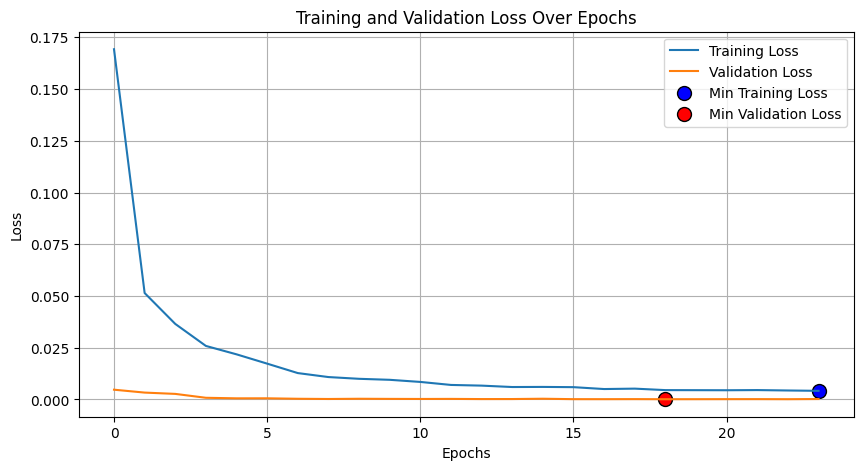

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
MAE: 0.01249032063292138
MSE: 0.00061306737047368
RMSE: 0.02476019730280193
R-Squared: 0.9874447540171475
MAE: 1074.048416772401
MSE: 4533240.357832719
RMSE: 2129.1407557586977
MAPE: 1.6533811027882903
R-Squared: 0.9874447540171475


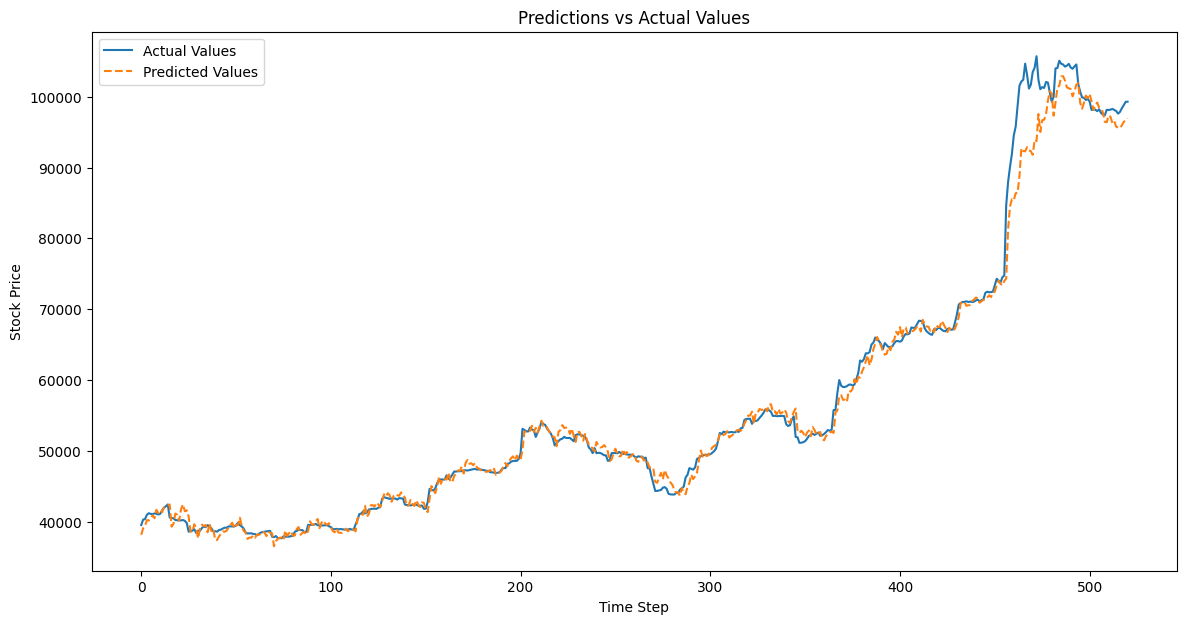

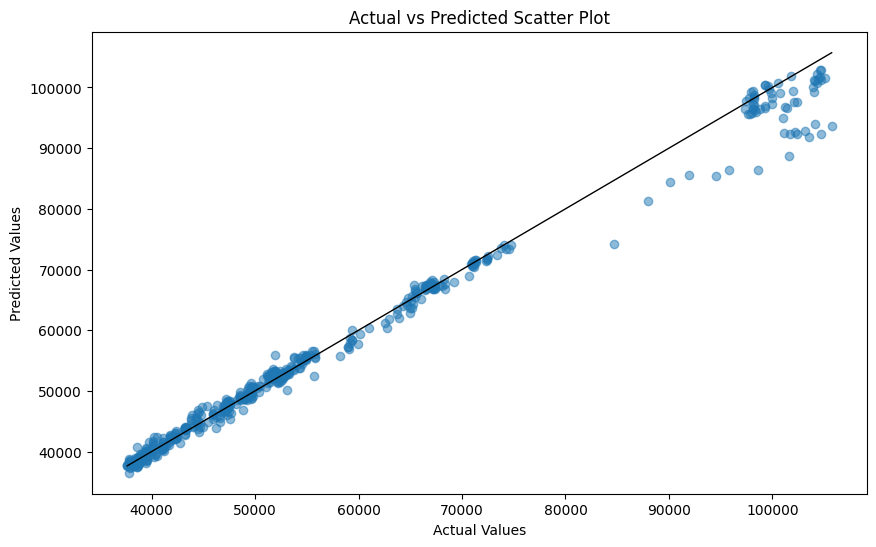

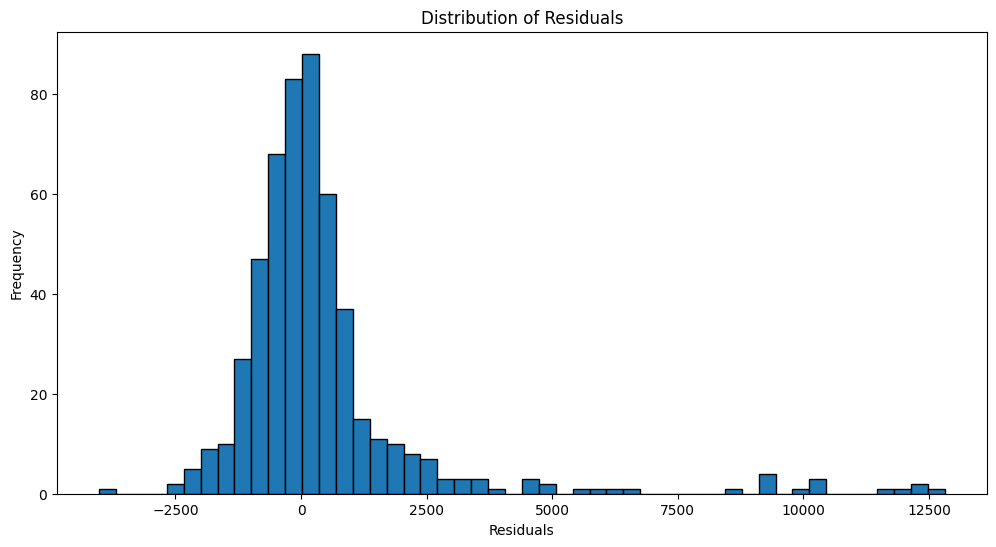

In [ ]:
# Assuming `history.history['loss']` and `history.history['val_loss']` contain your loss data

train_losses = history.history['loss']
val_losses = history.history['val_loss']

min_train_loss = min(train_losses)
min_val_loss = min(val_losses)
min_train_loss_index = train_losses.index(min_train_loss) + 1  # adding 1 to convert from index to epoch
min_val_loss_index = val_losses.index(min_val_loss) + 1

# Result Summary
results_summary = pd.DataFrame({
    "Metric": ["Training Loss", "Validation Loss"],
    "Minimum Value": [min_train_loss, min_val_loss],
    "Epoch": [min_train_loss_index, min_val_loss_index]
})

print(results_summary)

# Print Result
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(min_train_loss_index - 1, min_train_loss, color='blue', s=100, edgecolors='black', label='Min Training Loss')
plt.scatter(min_val_loss_index - 1, min_val_loss, color='red', s=100, edgecolors='black', label='Min Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
Y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-Squared: {r2}')

# Inverse scaling to get original values
Y_test_rescaled = scaler.inverse_transform(
    np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(features) - 1))), axis=1)
)[:, 0]
Y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((Y_pred, np.zeros((Y_pred.shape[0], len(features) - 1))), axis=1)
)[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)
mse = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((Y_test_rescaled - Y_pred_rescaled) / Y_test_rescaled)) * 100
r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R-Squared: {r2}')

# Plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(Y_test_rescaled, label='Actual Values')
plt.plot(Y_pred_rescaled, label='Predicted Values', linestyle='--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_rescaled, Y_pred_rescaled, alpha=0.5)
plt.plot([Y_test_rescaled.min(), Y_test_rescaled.max()], [Y_test_rescaled.min(), Y_test_rescaled.max()], 'k', lw=1)
plt.title('Actual vs Predicted Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

residuals = Y_test_rescaled.flatten() - Y_pred_rescaled.flatten()
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()